Problem

1.程式碼跑多次中，沒有把測試資料放進去，覺得模型訓練不應該包含測試資料才對。

2.預測結果跟真實資料差距多大是不ok？怎麼判斷，用準確率去算嗎

# 新增區段

In [ ]:
import pandas as pd
url="https://raw.githubusercontent.com/GrandmaCan/ML/main/Resgression/Salary_Data.csv"
data=pd.read_csv(url)
data

,YearsExperience,Salary
0,0.3,36.2
1,0.6,36.6
2,0.8,42.8
3,1.1,39.3
4,1.3,46.2
5,1.5,37.7
6,2.0,43.5
7,2.2,39.8
8,2.9,56.6
9,3.0,60.1


In [ ]:
#訓練集&測試集

from sklearn.model_selection import train_test_split
import torch
x=data["YearsExperience"]
y=data["Salary"]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

#把資料丟進模型訓練會發現資料型態不同。去看模型的dtype是多少model.linear_layer.weight.dtype，這邊的資料型態也跟著修改
#model.linear_layer.weight從model.state_dict()得知
x_train=torch.tensor(x_train.values,dtype=torch.float32)
x_test=torch.tensor(x_test.values,dtype=torch.float32)
y_train=torch.tensor(y_train.values,dtype=torch.float32)
y_test=torch.tensor(y_test.values,dtype=torch.float32)

In [ ]:
#使用pytorch建立模型，並使用GPU加速運算
#參考3-3是用sklearn建立模型

from torch import nn
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer=nn.Linear(in_features=1,out_features=1)
  def forward(self,x):
    return self.linear_layer(x)

model = LinearRegressionModel()
model=model.to("cuda")

In [ ]:
#把訓練跟測試集資料都設定到gpu上
x_train=x_train.to("cuda")
x_test=x_test.to("cuda")
y_train=y_train.to("cuda")
y_test=y_test.to("cuda")

In [ ]:
#把訓練集的資料丟進模型訓練
#計算損失函數

#把資料丟進模型訓練後，會發現矩陣形狀不符合
x_train=x_train.reshape(26,1)
#沒有加這個計算cost_fn會出現warning，兩個shpae不同
y_train=y_train.reshape(26,1)
y_pred=model(x_train)

cost_fn=nn.MSELoss()
cost=cost_fn(y_pred,y_train)
print(cost)
print(model.state_dict())

#發現不同裝置，要一起運算會發生錯誤。model在gpu上，訓練跟測試集都在cpu上，上面再加個程式碼。
#RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

tensor(5643.3740, device='cuda:0', grad_fn=<MseLossBackward0>)
OrderedDict([('linear_layer.weight', tensor([[0.6899]], device='cuda:0')), ('linear_layer.bias', tensor([-0.9757], device='cuda:0'))])


In [ ]:
#設定優化器，觀察初始w,b在計算梯度後的cost下降
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.01)
optimizer.zero_grad()
cost.backward()
optimizer.step()

y_pred=model(x_train)
cost=cost_fn(y_pred,y_train)
print(cost)
print(model.state_dict())

tensor(662.3372, device='cuda:0', grad_fn=<MseLossBackward0>)
OrderedDict([('linear_layer.weight', tensor([[9.3614]], device='cuda:0')), ('linear_layer.bias', tensor([0.4378], device='cuda:0'))])


In [ ]:
#跑多次，找到最佳w,b

cost_hist=[]
for epoch in range(10000):

  #訓練階段
  model.train()

  y_pred=model(x_train)
  cost=cost_fn(y_pred,y_train)

  #課程：不能把設定在gpu上的tensor轉換成numpy。所以先設定到cpu,再設定numpy。detach是為了把梯度消除，才有辦法繪製圖形
  #cost_hist.append(train_cost.cpu().detach().numpy())

  #原本寫的，在畫圖時會出錯，需要先把它轉到cpu上才有辦法繪圖
  # cost_hist.append(cost)
  #加上cpu後還是出現以下error。所以再加上detach
  #cost_hist.append(cost.cpu())
  #RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

  cost_hist.append(cost.cpu().detach())

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  #課程這裡有加入eval的，觀察test的cost下降。但我覺得訓練模型應該拿訓練階段訓練就好，測試集是最後再做測試

  if epoch%1000==0:
    print(f"epoch:{epoch:5},  cost:{cost: .4e}")


epoch:    0,  cost: 6.6234e+02
epoch: 1000,  cost: 2.4584e+01
epoch: 2000,  cost: 2.4577e+01
epoch: 3000,  cost: 2.4577e+01
epoch: 4000,  cost: 2.4577e+01
epoch: 5000,  cost: 2.4577e+01
epoch: 6000,  cost: 2.4577e+01
epoch: 7000,  cost: 2.4577e+01
epoch: 8000,  cost: 2.4577e+01
epoch: 9000,  cost: 2.4577e+01


Text(0, 0.5, 'cost')

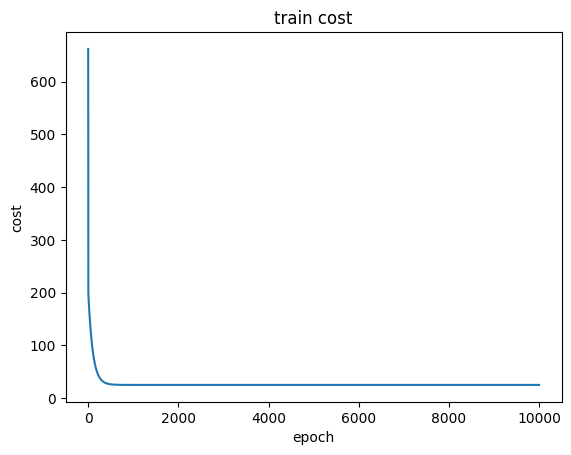

In [ ]:
#繪製圖形
import matplotlib.pyplot as plt
plt.plot(range(0,10000),cost_hist)
plt.title("train cost")
plt.xlabel("epoch")
plt.ylabel("cost")

#plt.plot(range(0,10000),cost_hist)出現error
#在gpu上的tensor無法轉成，要先轉成cpu
#TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[9.0363]], device='cuda:0')),
             ('linear_layer.bias', tensor([27.3232], device='cuda:0'))])

In [ ]:
#把大家形狀都改成一樣
x_train=x_train.reshape(-1,1)
y_train=y_train.reshape(-1,1)
x_test=x_test.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [ ]:
#觀察測試資料在模型上的表現

#測試階段
model.eval()
with torch.inference_mode():
  y_pred=model(x_test)

y_pred

tensor([[ 91.4811],
        [ 32.7450],
        [ 81.5412],
        [101.4211],
        [ 30.0341],
        [ 53.5286],
        [ 63.4685]], device='cuda:0')

In [ ]:
#觀察測試集丟到模型訓練出來的預測值，跟真實值的差距
y_pred,y_test

(tensor([[ 91.4811],
         [ 32.7450],
         [ 81.5412],
         [101.4211],
         [ 30.0341],
         [ 53.5286],
         [ 63.4685]], device='cuda:0'),
 tensor([[ 98.2000],
         [ 36.6000],
         [ 93.9000],
         [113.8000],
         [ 36.2000],
         [ 56.6000],
         [ 55.7000]], device='cuda:0'))